In [32]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from PredyNet_modules import PredyNet
import gym

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
env = gym.make("LunarLander-v2")
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([ 0.00149298,  0.93227835,  0.15121316, -0.5556771 , -0.00172326,
       -0.03425198,  0.        ,  0.        ])

In [148]:
action_space = env.action_space.n
obs_space = env.observation_space.shape[0]


In [286]:
ySize = 10
predynet = PredyNet(inSize=obs_space, dSize=ySize)
yPrev = torch.randn(ySize)
ePrev = torch.zeros(obs_space)
optimizer = torch.optim.SGD(predynet.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(predynet.parameters(), lr=0.01)
criterion = F.smooth_l1_loss
# criterion = nn.SmoothL1Loss()

In [287]:
act = env.action_space.sample()
observation = torch.Tensor(env.step(act)[0])

In [293]:
timelength = 10000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)

env.reset()
act = env.action_space.sample()

for t in range(timelength):
    if np.random.rand() < 0.1:
        act = env.action_space.sample()
        
    obs_out = env.step(act)
    observation = torch.Tensor(obs_out[0])
    done = obs_out[2]
    
    optimizer.zero_grad()

    err, ePrev, y, yPrev, Rec = predynet(observation[0], yPrev.detach(), ePrev)
    loss = criterion(Rec, observation)
    loss.backward()
    optimizer.step()
    
    rX[t] = obs_out[0][0]
    pX[t] = Rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    
    if done:
        env.reset()

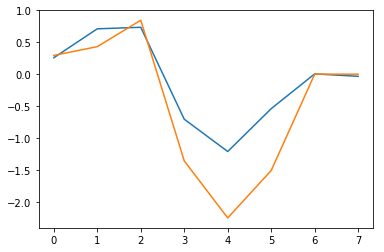

In [294]:
plt.plot(Rec.data.numpy())
plt.plot(obs_out[0])

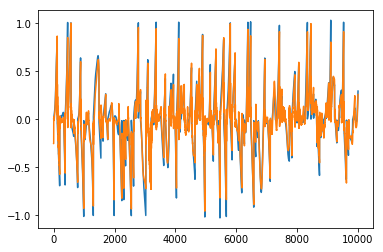

In [295]:
plt.plot(rX)
plt.plot(pX)
# plt.plot(rX-pX, 'r:')

In [296]:
timelength = 1000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)

env.reset()
act = env.action_space.sample()

for t in range(timelength):
    if np.random.rand() < 0.1:
        act = env.action_space.sample()
        
    obs_out = env.step(act)
    observation = torch.Tensor(obs_out[0])
    done = obs_out[2]
    
    err, ePrev, y, yPrev, Rec = predynet(observation[0], yPrev.detach(), ePrev)
    loss = criterion(Rec, observation)
    
    rX[t] = obs_out[0][0]
    pX[t] = Rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    
    if done:
        env.reset()

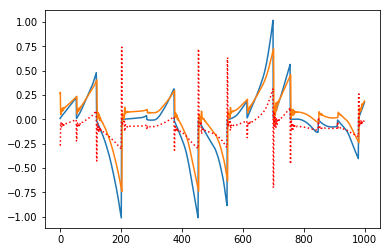

In [297]:
plt.plot(rX)
plt.plot(pX)
plt.plot(rX-pX, 'r:')